In [77]:
import shapefile
import pandas
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn
%matplotlib inline 
import random
import multiprocessing
import scipy
import copy
from scipy.stats import truncnorm


import warnings

MAX = float('inf')
MIN = float('-inf')


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):#Taken from https://stackoverflow.com/a/44308018
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def asymmetricallyUncertainChange(initial, uncertainty_below, uncertainty_above,
                                  minimum=MIN, maximum=MAX):
    if initial==0:
        return 0.0
    lower_bound = max(minimum, initial * (1-uncertainty_below))
    upper_bound = min(maximum, initial * (1+uncertainty_above))
    standard_deviation = (upper_bound - lower_bound)/6
    standard_deviation = max(standard_deviation, -1*standard_deviation)
    #print("{} , {} , {} , {}".format(initial, lower_bound, upper_bound, standard_deviation))
    new_value = get_truncated_normal(initial, standard_deviation, lower_bound, upper_bound).rvs()
    return new_value

def symmetricallyUncertainChange(initial, uncertainty, minimum=MIN, maximum=MAX):
    return asymmetricallyUncertainChange(initial, uncertainty, uncertainty, minimum, maximum)


def makeAsymmetricallyUncertainChanges(dataset, key, uncertainty_below, uncertainty_above, minimum=MIN, maximum=MAX):
    for i in range(len(dataset)):
        dataset.loc[i,key] = asymmetricallyUncertainChange(dataset[key].values[i], uncertainty_below, uncertainty_above, minimum, maximum)

def makeSymmetricallyUncertainChanges(dataset, key, uncertainty, minimum=MIN, maximum=MAX):
    makeAsymmetricallyUncertainChanges(dataset, key, uncertainty, uncertainty, minimum, maximum)


def project_to_year_from_two(year_wanted, dataset, tag_format, first_year, second_year):
    years_between_known = second_year - first_year
    years_to_wanted = year_wanted - second_year
    first_tag = tag_format.format(first_year)
    second_tag = tag_format.format(second_year)
    initial_projections = (dataset[second_tag] + years_to_wanted*((dataset[second_tag]-dataset[first_tag])/years_between_known))
    for i in range(len(initial_projections)):
        initial_projections[i] = max(0, initial_projections.values[i])
        if years_to_wanted==0:
            if initial_projections[i] - dataset[second_tag][i]:
                print(initial_projections[i], dataset[second_tag][i])
    return initial_projections


def getPredictions(dataset, training_predictors, training_outcomes, desired_predictors, model, type_string):
    model.fit(training_predictors, training_outcomes)
    training_predictions = model.predict(training_predictors)
    
    if print_mae:
        if type_string in []:#"NTL Historic"]:
            for i in range(len(training_predictions)):
                diff = np.abs(training_predictions[i] - training_outcomes[i])
                print("{}: {}, {}".format(diff, training_predictions[i], training_outcomes[i]))
            print(training_predictions)
            print(training_outcomes)
        training_mae = np.mean(np.abs(training_predictions - training_outcomes))
        print('{} Model MAE on Training Data: {}'.format(type_string, training_mae))
    
    if desired_predictors is None:
        return training_predictors
    return [training_predictors, model.predict(desired_predictors)]

def getNTLBasedPredictions(usa_dta):
    training_to_year = min(2016, historic_model_year)
    desired_from_year = min(2016, desired_year-1)
    training_from_year = training_to_year - (desired_year - desired_from_year)
    training_predictors = usa_dta[desired_stat.format(training_from_year)].values.reshape(len(usa_dta), 1)
    ntl_outcome = usa_dta[desired_stat.format(training_to_year)].values.reshape(len(usa_dta), 1)
    desired_predictors = usa_dta[desired_stat.format(desired_from_year)].values.reshape(len(usa_dta), 1)
    return getPredictions(usa_dta, training_predictors, ntl_outcome, desired_predictors, linear_model.LinearRegression(), "NTL Historic")

def getHistoricPredictions(usa_dta):
    training_predictors = usa_dta[historical_reshape_on].values.reshape(len(usa_dta), len(historical_reshape_on))
    desired_predictors = usa_dta[future_reshape_on].values.reshape(len(usa_dta), len(future_reshape_on))
    outcome = usa_dta[desired_stat.format(historic_model_year)].values.reshape(len(usa_dta), 1)
    return getPredictions(usa_dta, training_predictors, outcome, desired_predictors, linear_model.LinearRegression(), "Historic")

def getCombinedHistoricPredictions(usa_dta):
    results = getHistoricPredictions(usa_dta)
    usa_dta['training_historic_predictions'] = results[0][:,0]
    usa_dta['desired_historic_predictions'] = results[1]
    results = getNTLBasedPredictions(usa_dta)
    usa_dta['training_ntl_based_predictions'] = results[0][:,0]
    usa_dta['desired_ntl_based_predictions'] = results[1]
    training_predictors = usa_dta[['random', 'training_ntl_based_predictions']].values.reshape(len(usa_dta), 2)
    #training_predictors = usa_dta[['training_historic_predictions', 'training_ntl_based_predictions']].values.reshape(len(usa_dta), 2)
    training_outcomes = usa_dta[desired_stat.format(historic_model_year)].values.reshape(len(usa_dta), 1)
    desired_predictors = usa_dta[['desired_historic_predictions', 'desired_ntl_based_predictions']].values.reshape(len(usa_dta), 2)
    
    return getPredictions(usa_dta, training_predictors, training_outcomes, desired_predictors, linear_model.ElasticNet(), "Combined Historic")[1]



In [78]:

#have NTL data for 2012-2016
desired_year = 2016
historic_model_year = min(desired_year-1, 2016)
desired_stat = 'viirs_vcmcfg_dnb_composites_v10_yearly_max.{}.mean'
#we can use the projected pop instead of making our own

assert 2013 <= historic_model_year < desired_year <= 2020

usa_dta_initial = pandas.read_csv("./FinalData.csv")

usa_dta_initial.dropna(inplace=True, axis=1, thresh=len(usa_dta_initial)-10)
usa_dta_initial.reset_index(drop=True, inplace=True)
usa_dta_initial.dropna(inplace=True, axis=0)
usa_dta_initial.reset_index(drop=True, inplace=True)

pertinent_and_preds = copy.deepcopy(usa_dta_initial)[['gpw_v4_count.2015.sum',
                                                        'gpw_v4_density.2015.mean',
                                                        'access_50k.none.mean',
                                                        'distance_to_coast_236.none.mean',
                                                        'srtm_elevation_500m.none.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2012.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2013.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2014.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2015.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2016.mean',
                                                        'NAME_2']]

use_for_projections = copy.deepcopy(usa_dta_initial)[['gpw_v4_count.2010.sum',
                                                         'gpw_v4_count.2015.sum',
                                                         'gpw_v4_count.2020.sum',
                                                         'gpw_v4_density.2010.mean',
                                                         'gpw_v4_density.2015.mean',
                                                         'gpw_v4_density.2020.mean',
                                                         'ambient_air_pollution_2013_fus_calibrated.2010.mean',
                                                         'ambient_air_pollution_2013_fus_calibrated.2011.mean',
                                                         'ambient_air_pollution_2013_fus_calibrated.2012.mean',
                                                         'ambient_air_pollution_2013_fus_calibrated.2013.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2012.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2013.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2014.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2015.mean',
                                                        'viirs_vcmcfg_dnb_composites_v10_yearly_max.2016.mean',]]


if desired_year == 2020:
    pertinent_and_preds['gpw_v4_count.{}.sum.prediction'.format(desired_year)] = use_for_projections['gpw_v4_count.{}.sum'.format(desired_year)]
    pertinent_and_preds['gpw_v4_density.{}.mean.prediction'.format(desired_year)] = use_for_projections['gpw_v4_density.{}.mean'.format(desired_year)]
else:
    pertinent_and_preds['gpw_v4_count.{}.sum.prediction'.format(desired_year)] = project_to_year_from_two(desired_year, use_for_projections, 'gpw_v4_count.{}.sum', 2010, 2015)
    pertinent_and_preds['gpw_v4_density.{}.mean.prediction'.format(desired_year)] = project_to_year_from_two(desired_year, use_for_projections, 'gpw_v4_density.{}.mean', 2010, 2015)
pertinent_and_preds['gpw_v4_count.{}.sum.prediction'.format(historic_model_year)] = project_to_year_from_two(historic_model_year, use_for_projections, 'gpw_v4_count.{}.sum', 2010, 2015)
pertinent_and_preds['gpw_v4_density.{}.mean.prediction'.format(historic_model_year)] = project_to_year_from_two(historic_model_year, use_for_projections, 'gpw_v4_density.{}.mean', 2010, 2015)
pertinent_and_preds['ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(historic_model_year)] = project_to_year_from_two(desired_year, use_for_projections, 'ambient_air_pollution_2013_fus_calibrated.{}.mean', 2010, 2013)
pertinent_and_preds['ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(desired_year)] = project_to_year_from_two(desired_year, use_for_projections, 'ambient_air_pollution_2013_fus_calibrated.{}.mean', 2010, 2013)
#Confirm that that's better than shooting from 2012 and 2013.
pertinent_and_preds['random'] = pertinent_and_preds['gpw_v4_count.2015.sum'].apply(lambda x: (int(x)*0)+ random.random())

pertinent_and_preds['{}.prediction'.format(desired_stat).format(desired_year)] = project_to_year_from_two(desired_year, use_for_projections, desired_stat, 2012, 2016)

copy that into below:
    '{}.prediction'.format(desired_stat).format(desired_year)

historical_reshape_on = ['gpw_v4_count.{}.sum.prediction'.format(historic_model_year),
                         'gpw_v4_density.{}.mean.prediction'.format(historic_model_year),
                         'ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(historic_model_year),
                         'access_50k.none.mean',
                         'distance_to_coast_236.none.mean',
                         'srtm_elevation_500m.none.mean']

future_reshape_on = ['gpw_v4_count.{}.sum.prediction'.format(desired_year),
                     'gpw_v4_density.{}.mean.prediction'.format(desired_year),
                     'ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(desired_year),
                     'access_50k.none.mean',
                     'distance_to_coast_236.none.mean',
                     'srtm_elevation_500m.none.mean']

print_mae = True

def applyUncertainty(usa_dta):
    makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_count.2015.sum', 0.1, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_density.2015.mean', 0.1, 0)
    if desired_year == 2020:
        makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_count.{}.sum.prediction'.format(desired_year), 0.3, 0)
        makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_density.{}.mean.prediction'.format(desired_year), 0.3, 0)
    else:
        makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_count.{}.sum.prediction'.format(desired_year), 0.3, 0)
        makeSymmetricallyUncertainChanges(usa_dta, 'gpw_v4_density.{}.mean.prediction'.format(desired_year), 0.3, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(historic_model_year), 0.25, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'ambient_air_pollution_2013_fus_calibrated.{}.mean.prediction'.format(desired_year), 0.5, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'access_50k.none.mean', 0.25, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'distance_to_coast_236.none.mean', 0.1, 0)
    makeSymmetricallyUncertainChanges(usa_dta, 'srtm_elevation_500m.none.mean', 0.1)
    makeSymmetricallyUncertainChanges(usa_dta, '{}.prediction'.format(desired_stat).format(desired_year), 0.2, 0)


def make_predictions(worker_id):
    print("Worker {} starting.".format(worker_id))
    scipy.random.seed()

    usa_dta = copy.deepcopy(pertinent_and_preds)
    #applyUncertainty(usa_dta)
    predictions =  getCombinedHistoricPredictions(usa_dta)
    #I'm going to save the top 10 locations, and my overall accuracy at the 20% threshold
    #(i.e., number of estimates I get within 20%) based on the professionally predicted 2020 data.
    if desired_year <= 2016:
        abs_diff_pred = np.abs(predictions - usa_dta[desired_stat.format(desired_year)].values)
        if print_mae:
            print("Future Model MAE: {}".format(np.mean(abs_diff_pred)))
        twentyPercent = np.mean(abs_diff_pred <= usa_dta[desired_stat.format(desired_year)].values * 0.2)
    
    usa_dta['{}.prediction'.format(desired_stat).format(desired_year)] = predictions
    top = usa_dta.nlargest(10, '{}.prediction'.format(desired_stat).format(desired_year))
    
    with open("./sim_res/result_"+str(random.random())+".csv",mode='w') as file:
        for i in usa_dta.loc[usa_dta["NAME_2"].isin(top["NAME_2"].values)].NAME_2.values:
            file.write(i + ",")
        if desired_year <= 2016:
            file.write(str(np.mean(twentyPercent)))
    
    print("Worker {} finished.".format(worker_id))


usable_threads = multiprocessing.cpu_count()*2-2
pool = multiprocessing.Pool(usable_threads)

iterations = 1
result = pool.map(make_predictions, range(iterations))



Worker 0 starting.
Historic Model MAE on Training Data: 2.4877066321128796
NTL Historic Model MAE on Training Data: 0.575515324353808
Combined Historic Model MAE on Training Data: 5.07006272352097
Future Model MAE: 0.8406634856279064
Worker 0 finished.


In [ ]:
import glob
import os   
import pandas
import collections
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline 


all_files = glob.glob(os.path.join('./sim_res/', "*.csv"))   
df_set = (pandas.read_csv(f, header=None) for f in all_files)
all_simulation_results = pandas.concat(df_set, ignore_index=True)

if desired_year <= 2016:
    accuracy_metric = all_simulation_results[10].values
    all_simulation_results = all_simulation_results.drop(all_simulation_results.columns[10], axis=1)
    print(accuracy_metric)

flat_list = [item for sublist in all_simulation_results.values for item in sublist]
noNAList = [x for x in flat_list if str(x) != 'nan']
district_counts = collections.Counter(noNAList)
plt.bar(range(len(district_counts)), list(district_counts.values()), align='center')
plt.xticks(range(len(district_counts)), list(district_counts.keys()), rotation="vertical")
plt.ylabel("Number of Iterations in Top 10")
plt.xlabel("District Name")
plt.title("Districts in Top 10")
plt.show()



TypeError: unsupported operand type(s) for /: 'str' and 'int'

/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


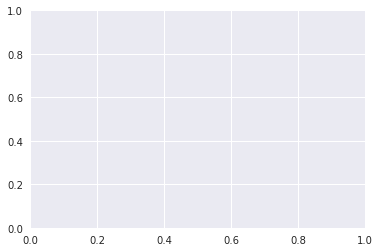

In [27]:
if desired_year <= 2016:
    seaborn.distplot(accuracy_metric, norm_hist=False, kde=False)